# Introduction to nussl

In this section, we will explore many source separation approaches through `nussl`, which is an open source python project featuring implementations of many methods. {cite}`nussl`


## Why nussl?

As we saw in the {ref}`opensrcmap` section, there are _a lot_ of open source projects for source separation. We certainly don't want do dissuade you from using those projects, because they contain a ton of amazing work. But why aren't we teaching each of those repositories? Why are we only teaching `nussl` in this tutorial?

* **nussl contains over a dozen source separation algorithms**:
    * nussl has ready-to-go implementations of classic and modern source separation algorithms. Learning nussl will give you access to all of them. In contrast, most of the open source projects for source separation only contain _one_ type of algorithm.

* **nussl is useful throughout the life cycle of a source separation algorithm**: 
    * With nussl, all of the code you need for training, evaluating, running, and interacting with the algorithms is included. Learning nussl means learning only one tool for all the individual steps necessary for source separation.
    
* **nussl supports common datasets**:
    * Whether for speech or for music, nussl one-stop-shop to interact with the most common datasets in the field.

* **nussl is easily extendable**:
    * Don't see what you like? nussl has a clear API to make it your own. We'll learn how to do this throughout the tutorial.

* **nussl is well-documented, well-tested, and actively maintained**:
    * Many of open source projects were created to produce research results in a scientific paper. Each one might have a different API and might require digging through the code base to learn. nussl has documentation ready to go and is designed to be clear and concise. It also has 100% complete test coverage that gets run on every push.



## Installing nussl

You can install nussl through pip like so:

- `pip install nussl`


In this tutorial, nussl is installed through the `common` utility library. This library was specifically created for the tutorial and will provide functions for us to visualize and interact with audio. It will also install `nussl` and `scaper` into the notebook environments for use on these pages.



## nussl Resources

This tutorial will guide you through using nussl, but for further details see the following links:

- [nussl's Github repository](https://github.com/nussl/nussl)
- [nussl's Documentation pages.](https://nussl.github.io/docs/)


## nussl Basics

First, let's cover the basics of `nussl`. This section is adapted from the [Introduction Section](https://nussl.github.io/docs/tutorials/audio_signal.html) of the `nussl` documentation.

## AudioSignals

The `nussl.AudioSignal()` object is the main container for all things related to your audio data. It provides a lot of helpful utilities to make it easy to manipulate your audio. Because it is at the heart of all of the source separation algorithms in nussl, it is crucial to understand how it works. Here we provide a brief introduction to many common tasks.


### Initialization from a File

It is easy to initialize an AudioSignal object by loading an audio file from a path. First, let’s use the external file zoo to get an audio file to play around with.

In [ ]:
%%capture
!pip install git+https://github.com/source-separation/tutorial

In [2]:
import warnings
warnings.simplefilter('ignore')
import nussl

In [3]:
# Let's download a file from the External File Zoo
input_file_path = nussl.efz_utils.download_audio_file('schoolboy_fascination_excerpt.wav')

This returns a path. Let's initialize an AudioSignal object with that path:

In [3]:
signal1 = nussl.AudioSignal(input_file_path)

Now the AudioSignal object is ready with all of the information about our the signal. Let’s also embed the audio signal in a playable object right inside this notebook so we can listen to it!

In [1]:
print(signal1)

NameError: name 'signal1' is not defined

In [2]:
_ = signal1.embed_audio()

NameError: name 'signal1' is not defined

AudioSignals pack in a lot of useful functionality. For example:

In [1]:
print("Duration: {} seconds".format(signal1.signal_duration))
print("Duration in samples: {} samples".format(signal1.signal_length))
print("Number of channels: {} channels".format(signal1.num_channels))
print("File name: {}".format(signal1.file_name))
print("Full path to input: {}".format(signal1.path_to_input_file))
print("Root mean square energy: {:.4f}".format(signal1.rms().mean()))

NameError: name 'signal1' is not defined

The actual signal data is in `signal1.audio_data`. It’s just a numpy array, so we can use it as such:

In [6]:
signal1.audio_data

array([[ 0.00213623, -0.04547119, -0.0513916 , ..., -0.24395752,
        -0.2310791 , -0.20785522],
       [-0.1791687 , -0.20150757, -0.20574951, ..., -0.23834229,
        -0.2156372 , -0.168396  ]], dtype=float32)

In [7]:
signal1.audio_data.shape

(2, 661500)

A few things to note here:

1. When AudioSignal loads a file, it converts the data to floats between [-1, 1]
2. The number of channels is the first dimension, the number of samples is the second.


### Initialization from a numpy array

Another common way to initialize an AudioSignal object is by passing in a numpy array. Let’s first make a single channel signal within a numpy array.

In [8]:
import numpy as np

sample_rate = 44100  # Hz
dt = 1.0 / sample_rate
dur = 2.0  # seconds
freq = 440  # Hz
x = np.arange(0.0, dur, dt)
x = np.sin(2 * np.pi * freq * x)

Cool! Now let’s put this into a new AudioSignal object.

In [9]:
signal2 = nussl.AudioSignal(
    audio_data_array=x, sample_rate=sample_rate)
signal2.embed_audio()
print(signal2)

AudioSignal (unlabeled): 2.000 sec @ path unknown, 44100 Hz, 1 ch.


Note that we had to give a sample rate. If no sample rate is given, then the following is used:

In [10]:
print(f"Default sample rate: {nussl.constants.DEFAULT_SAMPLE_RATE}")

Default sample rate: 44100


## Other Basic Manipulations

If we want to add the audio data in these two signals, it’s simple. But there are some gotchas:

In [11]:
signal3 = signal1 + signal2

AudioSignalException: Cannot do operation with two signals that have a different number of channels!

Uh oh! I guess it doesn’t make sense to add a stereo signal (`signal1`) and mono signal (`signal2`). But if we really want to add these two signals, we can make one of them mono.

`nussl` does this by simply averaging the two channels at every sample. We have to explicitly tell `nussl` that we are okay with `to_mono()` changing `audio_data`. We do that like this:

In [12]:
print(signal1.to_mono(overwrite=True))

AudioSignal (unlabeled): 15.000 sec @ /Users/ethanmanilow/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 1 ch.


If we hadn’t set `overwrite=True` then `to_mono()` would just return a new audio signal that is an exact copy of `signal1` except it is mono. You will see this pattern come up again. In certain places, `AudioSignal`’s default behavior is to overwrite its internal data, and in other places the default is to not overwrite data. See the reference pages for more info. Let’s try:

In [13]:
signal3 = signal1 + signal2

AudioSignalException: Cannot do arithmetic with signals of different length!

Uh oh! Let’s fix this by truncating the longer `signal1` to match `signal2` duration in seconds.

In [14]:
signal1.truncate_seconds(signal2.signal_duration)
print(signal1)

AudioSignal (unlabeled): 2.000 sec @ /Users/ethanmanilow/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 1 ch.


Now we can finally add them. The adding of these two signals clips, so let’s also peak normalize the audio data.

In [15]:
signal3 = signal1 + signal2
signal3.peak_normalize()
signal3.embed_audio()
print(signal3)

AudioSignal (unlabeled): 2.000 sec @ /Users/ethanmanilow/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 1 ch.


No exceptions this time! Great! `signal3` is now a new AudioSignal object. We can similarly subtract two signals.

Let's write this to a file:

In [16]:
signal3.write_audio_to_file('/tmp/signal3.wav')

Awesome! Now lets see how we can manipulate the audio in the frequency domain…

## Time-frequency representations

Most source separation algorithms do not their operations in the time domain, but rather in the frequency domain. For this, nussl provides an interface for working with Short-Time Fourier Transform (STFT) data. Here, we describe how to do some simple STFT operations with the `nussl.AudioSignal` object. Other time-frequency representations such as the constant-Q transform are not in nussl at this time.


### STFT Basics

Let’s reinitialize `signal1`. We should be able to get frequency domain data by looking at `signal1.stft_data`. Let’s try that.

In [19]:
signal1 = nussl.AudioSignal(input_file_path)
print('STFT Data:', signal1.stft_data)

STFT Data: None


Whoops! Because this object was initialized from a `.wav` file (i.e., time-series data), this `AudioSignal` object has no frequency domain data by default. To populate it with frequency data we do thusly:

In [20]:
stft = signal1.stft()
print(stft.shape)

(1025, 1293, 2)


Aha! Now we can examine how STFT data is stored in the `AudioSignal` object. Similar to `signal1.audio_data`, STFT data is stored in a (complex-valued) numpy array called `signal1.stft_data`:

In [23]:
signal1.stft_data.shape

(1025, 1293, 2)

By inspecting the shape we see that the first dimension represents the number of FFT bins taken at each hop, the second represents the length of our signal (in hops), and the third dimension is number of channels.

We can also get power spectrogram data from our signal as well. As we would expect, this is the same shape as `signal1.stft_data`:

In [21]:
# np.abs(signal1.stft_data) ** 2
psd = signal1.power_spectrogram_data
print(psd.shape)

(1025, 1293, 2)


Let’s take a look at the spectrogram, using some helpful functions from `nussl.utils`, with different settings on the y_axis.

/Users/ethanmanilow/opt/anaconda3/envs/ismir2020-tutorial/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/ethanmanilow/opt/anaconda3/envs/ismir2020-tutorial/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/ethanmanilow/opt/anaconda3/envs/ismir2020-tutorial/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


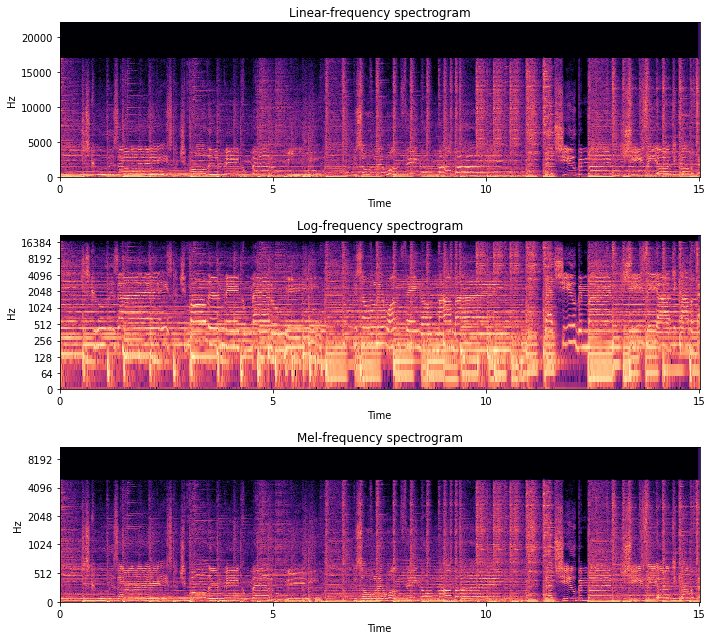

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))
plt.subplot(311)
plt.title('Linear-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1)

plt.subplot(312)
plt.title('Log-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1, y_axis='log')

plt.subplot(313)
plt.title('Mel-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1, y_axis='mel')

plt.tight_layout()
plt.show()

### Inverse STFTs

Let’s do something a little more interesting with our `AudioSignal` object. Since `signal1.stft_data` is just a regular numpy array, we can access and manipulate it as such. So let’s implement a low pass filter by creating a new `AudioSignal` object and leaving `signal1` unaltered.

Let’s eliminate all frequencies above about 1000 Hz in our signal.

In [24]:
import numpy as np

lp_stft = signal1.stft_data.copy()
lp_cutoff = 1000  # Hz
frequency_vector = signal1.freq_vector  # a vector of frequency values for each FFT bin
idx = (np.abs(frequency_vector - lp_cutoff)).argmin()  # trick to find the index of the closest value to lp_cutoff
lp_stft[idx:, :, :] = 0.0j  # every freq above lp_cutoff is 0 now

Okay, so now we have low passed STFT data in the numpy array `lp_stft`. Now we are going to see how we can initialize a new `AudioSignal` object using this data. Let’s make a copy of the original signal, `signal1`, using its helper function `make_copy_with_stft_data()`:

In [26]:
signal1_lp = signal1.make_copy_with_stft_data(lp_stft)
print('Audio Data:', signal1_lp.audio_data)

Audio Data: None


Easy-peasy! Now `signal1_lp` is a new AudioSignal object that has been initialized with STFT data instead of time series data.

But look at that: there’s no audio data to listen to! Before we can hear the result, we need to do an Inverse STFT to get back time-series data:

In [27]:
signal1_lp.istft()
signal1_lp.embed_audio()
print(signal1_lp)

AudioSignal (unlabeled): 15.000 sec @ /Users/ethanmanilow/.nussl/audio/schoolboy_fascination_excerpt.wav, 44100 Hz, 2 ch.


Let’s check out what the spectrogram looks like.

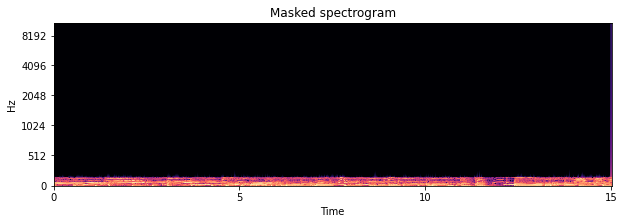

In [31]:
plt.figure(figsize=(10, 3))
plt.title('Masked spectrogram')
nussl.utils.visualize_spectrogram(signal1_lp, y_axis='mel')
plt.show()

### STFT Parameters

Where did the STFT parameters for our audio signals come from? As a reminder, there are three main arguments for taking an STFT:

1. `window_length`: How long are the windows within which to take the FFT?

2. `hop_length`: How much to hop between windows?

3. `window_type`: What sort of windowing function to use?

These three parameters are grouped into a `namedtuple` object that belongs to every `AudioSignal` object. This is the `STFTParams` object:

In [32]:
nussl.STFTParams

nussl.core.audio_signal.STFTParams

When we created the audio signals above, the STFT parameters were built on initialization:

In [33]:
signal1.stft_params

STFTParams(window_length=2048, hop_length=512, window_type='sqrt_hann')

The STFT parameters are built using helpful defaults based on properties of the audo signal. 32 millisecond windows are used with an 8 millisecond hop between windows. At 44100 Hz, this results in 2048 for the window length and 512 for the hop length. The window type is the `sqrt_hann` window, which we've noticed has better separation performance overall. There are many windows that can be used:

In [34]:
nussl.constants.ALL_WINDOWS

['hamming', 'rectangular', 'hann', 'blackman', 'triang', 'sqrt_hann']

An AudioSignal’s STFT parameters can be set after the fact. Let’s change the one for `signal1`:

In [35]:
signal1.stft_params = nussl.STFTParams(
    window_length=256, hop_length=128)
signal1.stft().shape

(129, 5169, 2)

The shape of the resultant STFT is now different. Note that 256 resulted in 129 frequencies of analysis per frame. In general, the rule is `(window_length // 2) + 1`.

## Next Steps...

With this in place, we can now learn about masking in the next section.